In [3]:
import pandas as pd

import glob
import os
from preprocess_utils import clip_raster_with_vector
from preprocess_utils import convert_raster_to_array

import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (FunctionTransformer,
                                   PolynomialFeatures,
                                   MinMaxScaler,
                                   )
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA


<h2>Data Preparation</h2>

Prepare the raster file, the bands, and the classes.

In [2]:
# Load raster
raster_file = 'raster/sample_image.tif'
number_bands = 8
band_names = ["CoastalBlue", "Blue", "GreenI", "Green", "Yellow", "Red", "RedEdge", "NIR"]

# Create a list of the names of the classes
class_list = ["bare", "builtup", "burned", "dense_vegetation", "shrubs", "sugarcane", "water"]


<h3>Mask raster to classes</h3>

Clip the raster to regions of interests collected in the field.

In [3]:
# List ROIs
geojson_list = glob.glob(os.path.join("geojson", "*.geojson"))

# Loop to all GeoJSON files and clip raster
for geojson in geojson_list:
    print(f"Processing {geojson}...")
    # Get the name of the class without the extension
    class_name = os.path.splitext(os.path.basename(geojson))[0]
    # Generate output path with the name of the class
    out_raster = os.path.join("raster", f"{class_name}.tif")
    # Clip the raster with the GeoJSON
    clip_raster_with_vector(raster_path=raster_file,
                            geojson_path=geojson,
                            output_raster_path=out_raster)
    print(f"Done processing {geojson}.")

Processing geojson/sugarcane.geojson...
Done processing geojson/sugarcane.geojson.
Processing geojson/builtup.geojson...
Done processing geojson/builtup.geojson.
Processing geojson/shrubs.geojson...
Done processing geojson/shrubs.geojson.
Processing geojson/dense_vegetation.geojson...
Done processing geojson/dense_vegetation.geojson.
Processing geojson/bare.geojson...
Done processing geojson/bare.geojson.
Processing geojson/burned.geojson...
Done processing geojson/burned.geojson.
Processing geojson/water.geojson...
Done processing geojson/water.geojson.


<h2>Export Input Files for Model</h2>

First, let's create CSV files for each of the classes. Saving each class as CSVs will improve the workflow for analysis.

In [9]:
# Get the list of the clipped raster
clipped_rasters = glob.glob(os.path.join("raster", "*.tif"))

for class_raster in clipped_rasters:
    # Get the name of the raster file
    class_name = os.path.splitext(os.path.basename(class_raster))[0]
    if class_name in class_list:
        print(f"Processing {class_name}...")
        # Create a list to store the dataframes
        df_bands = []

        # Convert class raster to array
        array = convert_raster_to_array(class_raster)

        # Loop through the bands
        for band_idx, band_name in zip(range(number_bands), band_names):
            # Flatten array
            flattened_array = array[band_idx, :, :].flatten()
            # Convert to dataframe and set column name
            band_df = pd.DataFrame(flattened_array, columns=[band_name])
            # Append dataframe to list
            df_bands.append(band_df)

        # Concatenate all the appended dataframes 
        out_df = pd.concat(df_bands, axis=1)

        # Remove rows where all columns have no data
        out_df.dropna(how='all', inplace=True)

        # Add a column to store the name of the class
        out_df["Class"] = class_name

        # Save the dataframe to CSV
        out_df.to_csv(os.path.join("csv", f"{class_name}.csv"), index=False)

        print(f"Finished processing {class_name}.")

Processing burned...
Finished processing burned.
Processing builtup...
Finished processing builtup.
Processing sugarcane...
Finished processing sugarcane.
Processing dense_vegetation...
Finished processing dense_vegetation.
Processing shrubs...
Finished processing shrubs.
Processing water...
Finished processing water.
Processing bare...
Finished processing bare.


Create a single CSV file to store all of the classes.

In [10]:
# Generate a list contaning all the generated CSVs
class_csv = glob.glob(os.path.join("csv", "*.csv"))

# Create a list to store the dataframes
df_class = []

for csv in class_csv:
    # Get the name of the csv file
    class_name = os.path.splitext(os.path.basename(csv))[0]
    if class_name in class_list:
        # Read CSV file
        df_csv = pd.read_csv(csv)
        # Append to list
        df_class.append(df_csv)

# Concatenante the dataframes
out_class_df = pd.concat(df_class, axis=0)

# Save to new CSV file
out_class_df.to_csv(os.path.join("csv", "dataset.csv"), index=False)


<h2>Exploratory Data Analysis</h2>

We will conduct exploratory data analysis to check the spread of data.

First, import the data and remove duplicates and rows with null values

In [4]:
# Set the path of the merged CSV 
merged_csv = os.path.join("csv", "dataset.csv")

In [5]:
dataset = pd.read_csv(merged_csv)

# drop duplicates
dataset = dataset.drop_duplicates()

# drop rows with null values
dataset = dataset.dropna()

dataset

,CoastalBlue,Blue,GreenI,Green,Yellow,Red,RedEdge,NIR,Class
0,553.0,571.0,913.0,1032.0,945.0,800.0,1687.0,3945.0,shrubs
1,589.0,578.0,902.0,1050.0,942.0,819.0,1663.0,3991.0,shrubs
2,583.0,563.0,903.0,1048.0,934.0,775.0,1659.0,3955.0,shrubs
3,569.0,554.0,894.0,1042.0,941.0,736.0,1641.0,3941.0,shrubs
4,571.0,558.0,911.0,1034.0,940.0,739.0,1636.0,4045.0,shrubs
...,...,...,...,...,...,...,...,...,...
38054,585.0,542.0,666.0,791.0,804.0,925.0,1048.0,1863.0,burned
38055,596.0,569.0,678.0,796.0,817.0,917.0,1042.0,1788.0,burned
38056,539.0,570.0,687.0,794.0,852.0,878.0,1030.0,1758.0,burned
38057,506.0,565.0,685.0,783.0,868.0,861.0,1037.0,1765.0,burned


Visualize the points per sample and check the distribution of the values

<Figure size 1200x800 with 0 Axes>

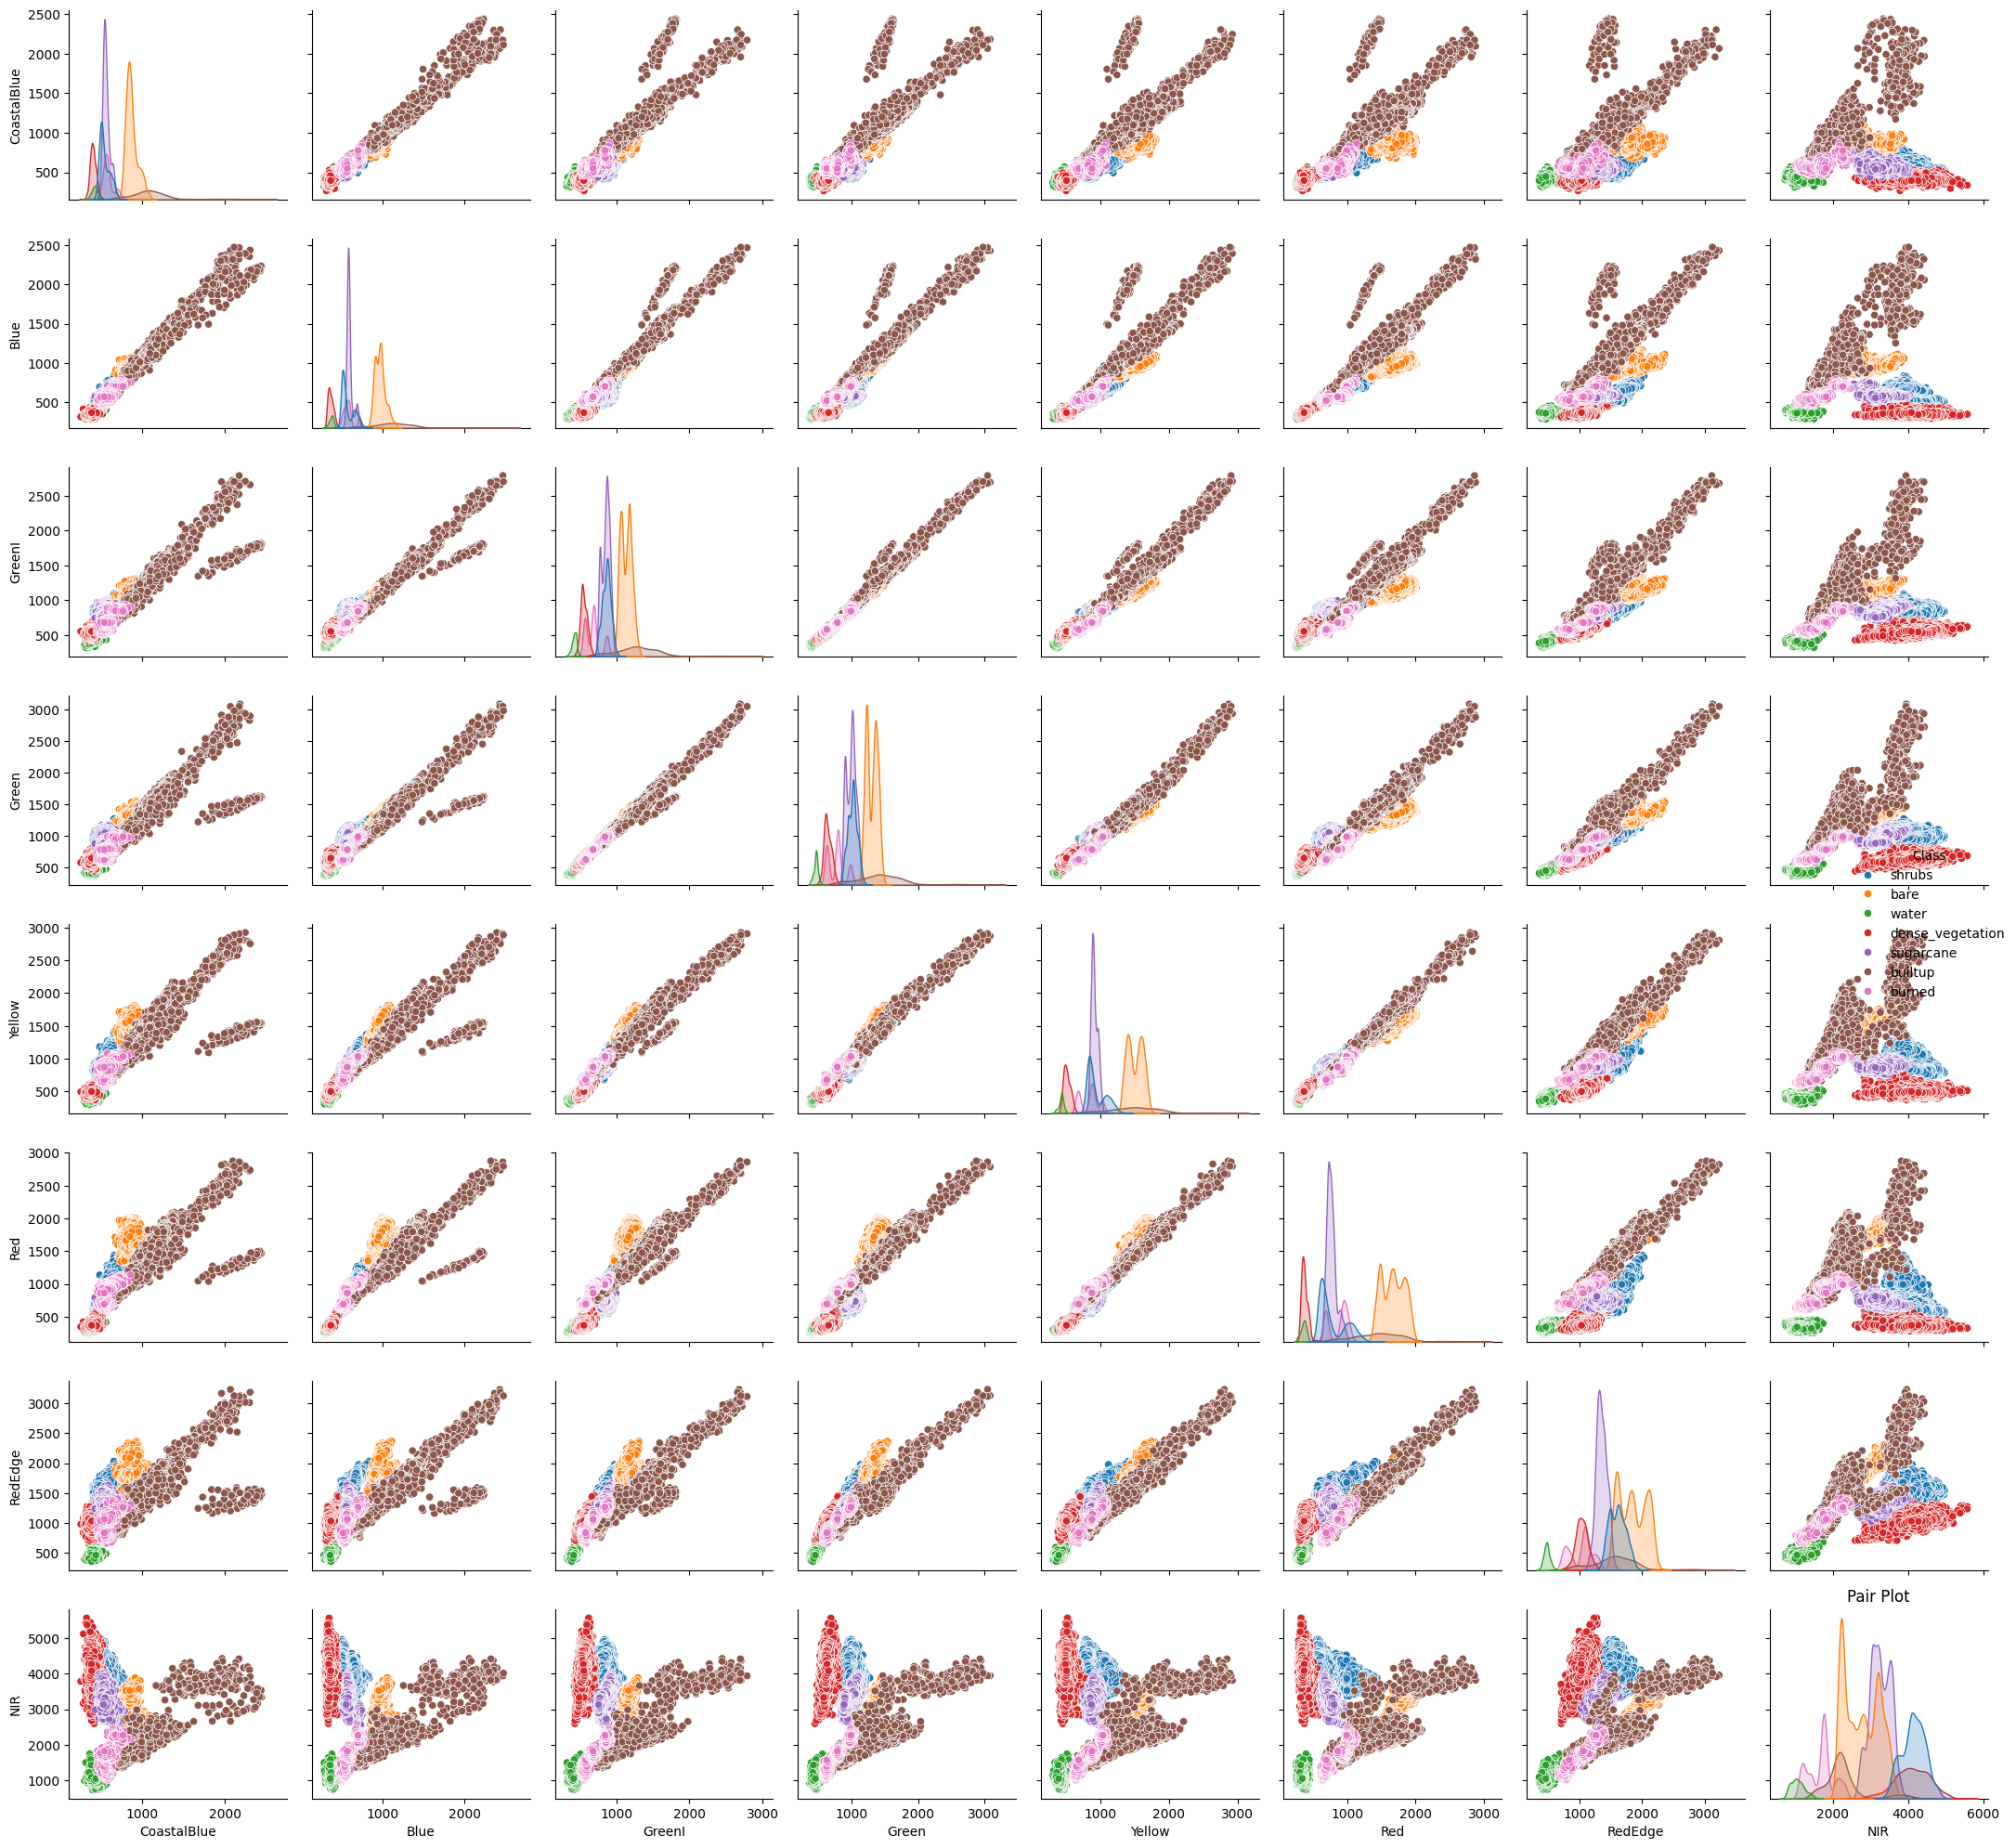

In [15]:
from visualization_utils import make_pairplot

# Create a pair plot 
make_pairplot(dataset, 'Class')

Insights:
* Classes have a more noticeable cluster the longer the wavelength (such as from Red, RedEdge, and NIR)

Another way to visualize the spread of the data is to use a box plot. However, instead of showing the spread of data along each band, we can separate the box plot per class.

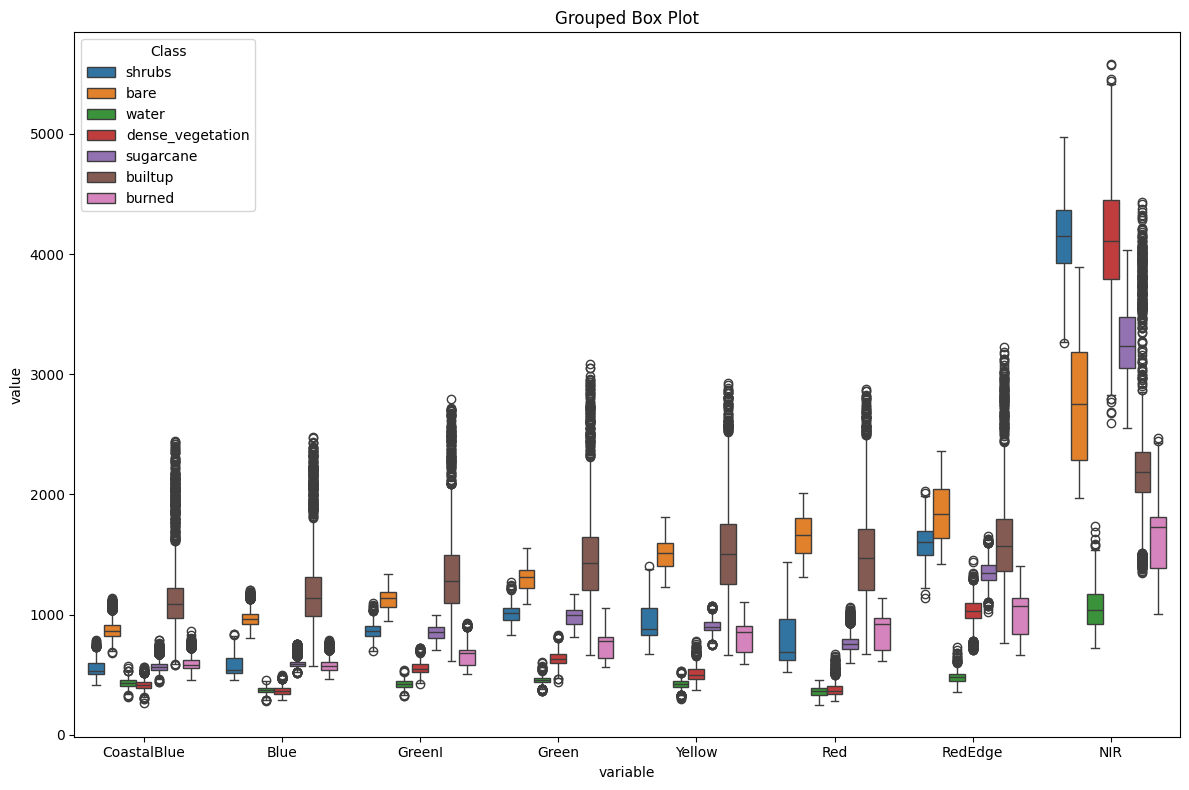

In [4]:
from visualization_utils import make_grouped_boxplot

# Create a grouped box plot
make_grouped_boxplot(dataset, 'Class')

We can see a better view of the data with a box plot and now we can see that there are a lot of outliers in most of the classes for every band. However, outliers are very common in satellite imagery.

Visually, the best band seems to be NIR as it shows the most separability for each class.

Next, we can generate a correlation matrix to determine which variables are correlated with each other.

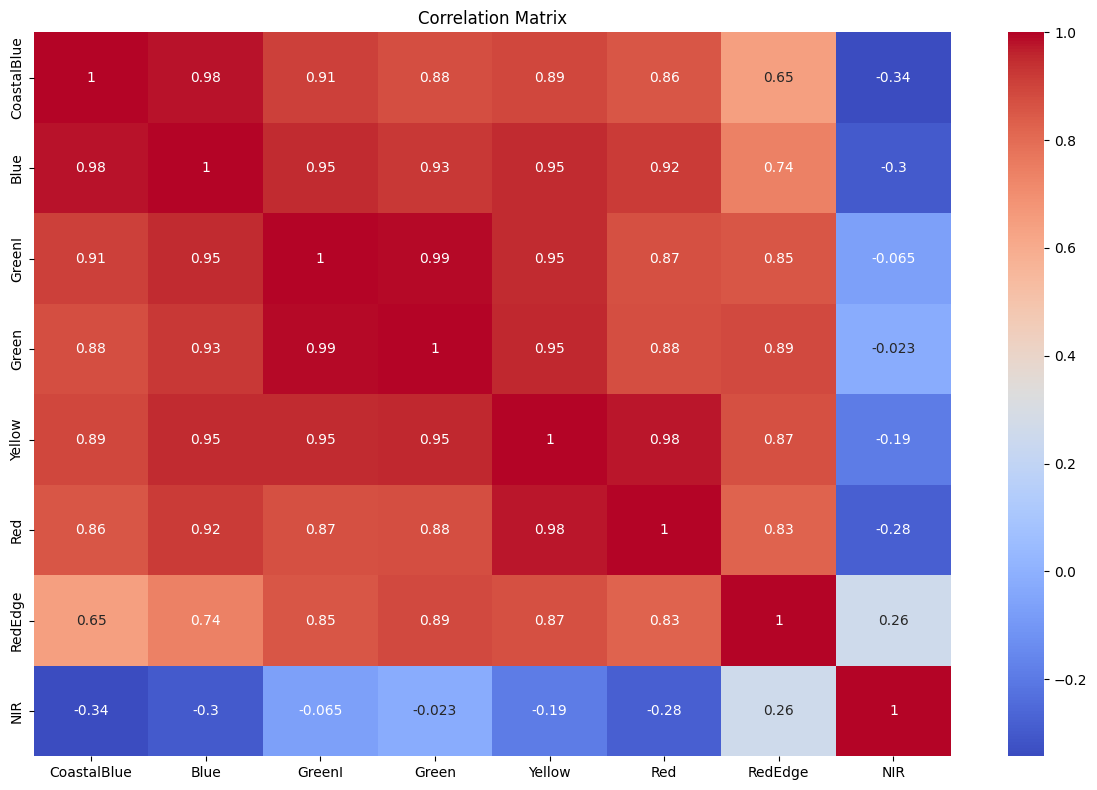

In [6]:
from visualization_utils import make_correlation_matrix

# create a heat map plot
make_correlation_matrix(dataset[band_names])

We can see high positive correlation on some bands like Coastal Blue and Blue, and Green and Green I. Depending on the objectives of a project, highly correlated bands can be removed. Moderately correlated values and below should be retained as they may help capture unique information.

For this project, let's assume that all bands are essential. We will now add additional bands that can provide additional dimensions for the classifier.

In [10]:
# Rearrange the columns for readability
final_df = dataset[['Class']+ band_names]
final_df

,Class,CoastalBlue,Blue,GreenI,Green,Yellow,Red,RedEdge,NIR
0,shrubs,553.0,571.0,913.0,1032.0,945.0,800.0,1687.0,3945.0
1,shrubs,589.0,578.0,902.0,1050.0,942.0,819.0,1663.0,3991.0
2,shrubs,583.0,563.0,903.0,1048.0,934.0,775.0,1659.0,3955.0
3,shrubs,569.0,554.0,894.0,1042.0,941.0,736.0,1641.0,3941.0
4,shrubs,571.0,558.0,911.0,1034.0,940.0,739.0,1636.0,4045.0
...,...,...,...,...,...,...,...,...,...
38054,burned,585.0,542.0,666.0,791.0,804.0,925.0,1048.0,1863.0
38055,burned,596.0,569.0,678.0,796.0,817.0,917.0,1042.0,1788.0
38056,burned,539.0,570.0,687.0,794.0,852.0,878.0,1030.0,1758.0
38057,burned,506.0,565.0,685.0,783.0,868.0,861.0,1037.0,1765.0


Let's create vegetation indices that can help add dimension to the data.

In [11]:
# Create new columns representing vegetation indices
final_df['NDRI'] = (final_df['NIR']-final_df['RedEdge'])/(final_df['NIR']+final_df['RedEdge'])
final_df['NDGI'] = (final_df['NIR']-final_df['Green'])/(final_df['NIR']+final_df['Green'])
final_df['CIre'] = (final_df['RedEdge']/final_df['Green'])-1
final_df

/var/folders/10/q1d556sn00s5n9f8wr3k038w0000gn/T/ipykernel_83405/379035785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['NDRI'] = (final_df['NIR']-final_df['RedEdge'])/(final_df['NIR']+final_df['RedEdge'])
/var/folders/10/q1d556sn00s5n9f8wr3k038w0000gn/T/ipykernel_83405/379035785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['NDGI'] = (final_df['NIR']-final_df['Green'])/(final_df['NIR']+final_df['Green'])
/var/folders/10/q1d556sn00s5n9f8wr3k038w0000gn/T/ipykernel_83405/3790357

,Class,CoastalBlue,Blue,GreenI,Green,Yellow,Red,RedEdge,NIR,NDRI,NDGI,CIre
0,shrubs,553.0,571.0,913.0,1032.0,945.0,800.0,1687.0,3945.0,0.400923,0.585292,0.634690
1,shrubs,589.0,578.0,902.0,1050.0,942.0,819.0,1663.0,3991.0,0.411744,0.583416,0.583810
2,shrubs,583.0,563.0,903.0,1048.0,934.0,775.0,1659.0,3955.0,0.408978,0.581051,0.583015
3,shrubs,569.0,554.0,894.0,1042.0,941.0,736.0,1641.0,3941.0,0.412039,0.581778,0.574856
4,shrubs,571.0,558.0,911.0,1034.0,940.0,739.0,1636.0,4045.0,0.424045,0.592833,0.582205
...,...,...,...,...,...,...,...,...,...,...,...,...
38054,burned,585.0,542.0,666.0,791.0,804.0,925.0,1048.0,1863.0,0.279973,0.403919,0.324905
38055,burned,596.0,569.0,678.0,796.0,817.0,917.0,1042.0,1788.0,0.263604,0.383901,0.309045
38056,burned,539.0,570.0,687.0,794.0,852.0,878.0,1030.0,1758.0,0.261119,0.377743,0.297229
38057,burned,506.0,565.0,685.0,783.0,868.0,861.0,1037.0,1765.0,0.259814,0.385400,0.324393


Then, save to CSV for use in the next section.

In [12]:
# Save to new CSV file
final_df.to_csv(os.path.join("csv", "dataset_expanded.csv"), index=False)

<h1>Data Preparation</h1>

Let's prepare the data for machine learning. One of the first steps is to split the data into training and validation data.

In [3]:
# Load the CSV file
trimmed_df = pd.read_csv(os.path.join("csv", "dataset_expanded.csv"))

We can set the split proportion to be: 70% training and 30% validation.

In [4]:
from preprocess_utils import split_data

# Split the data to train and test sets
X_train, X_test, y_train, y_test= split_data(trimmed_df, 'Class', 0.3, 1)

In [5]:
# Save the data to CSV
X_train.to_csv(os.path.join("csv", "X_train.csv"), index=False)
X_test.to_csv(os.path.join("csv", "X_test.csv"), index=False)
y_train.to_csv(os.path.join("csv", "y_train.csv"), index=False)
y_test.to_csv(os.path.join("csv", "y_test.csv"), index=False)

<h2>Variable Selection</h2>

One important component in developing models is to select important variables. It can be determined through prior publications and even expert consultations. Additionally, it can be determined quantitatively such as applying <b>permutation importance</b> on a set of variables. In this section, a permutation importance algorithm will be used to quantitatively determine the best variable for the model.

Before calculating the important variables, we can add features or dimensions in the data through <b>feature engineering</b>. While the input dataset included vegetation indices, we can still add more features such as those derived from statistical tools. Adding features to the data can help with the performance of the model, although it may also incur additional processing cost or lead to overfitting, for example.

In [63]:
# Read the CSV files

X_train = pd.read_csv(os.path.join("csv", "X_train.csv"))
X_test = pd.read_csv(os.path.join("csv", "X_test.csv"))
y_train = pd.read_csv(os.path.join("csv", "y_train.csv"))
y_test = pd.read_csv(os.path.join("csv", "y_test.csv"))

<h3>Log Transformation</h3>

Earlier, we saw that the data has a lot of outliers or heavily skewed in one direction. A method that can help reduce the skewness is log transformation. One benefit of log transformation is that the data will be more suited to algorithms that assume a normally-distributed data.

In [64]:
from preprocess_utils import log_transform

# Get the columns containing numerical data
num_df = X_train.select_dtypes(include=["float64"]).columns.tolist()

# Apply log transform
X_train_log, X_test_log = log_transform(X_train, X_test, num_df)


<h4>Polynomial Transformation</h4>
Polynomial transformations are a feature engineering tool that transforms values up to a specified polynomial degree. It helps separate the data points, such as capturing the combined effect of variables, and can yield a better performing model.

Here, we will set the transformation up to the second polynomial degree.

In [65]:
from preprocess_utils import poly_transform

# Apply polynomial transform
X_train_poly, X_test_poly = poly_transform(X_train_log, X_test_log, num_df, 2)


<h3>Data Scaling</h3>

Data scaling is an important step in machine learning to fit with the requirements of algorithms. Some benefits of scaling include: (1) improved model performance with equal distances of the features, (2) speed up algorithms with similar scaling, and (3) sets equal weights to all features, reducing importance bias on uneven scales.

In [66]:
from preprocess_utils import scale_to_min_max

# Scale the data to min-max 
X_train_scaled, X_test_scaled = scale_to_min_max(X_train_poly, X_test_poly)


<h3>Principal Components Analysis</h3>

Principal Components Analysis (PCA) can be used as a technique to reduce the dimensionality of a dataset. The original features are transformed into uncorrelated features, called principal components. Applying PCA can help improve the performance of models by introducing a component that filter out noise in the data.

In [67]:
from preprocess_utils import run_pca

# Run PCA using 8 components
# It is assumed that the first 8 bands explain at least 95% of the variance
X_train_pca, X_test_pca = run_pca(
    X_train_scaled, X_test_scaled, n_components=8)

# Scale the output
X_train_pca_scaled, X_test_pca_scaled = scale_to_min_max(X_train_pca, X_test_pca)


<h3>Linear Discriminant Analysis</h3>

Linear Discriminant Analysis is also a dimensionality reduction technique, similar to PCA, that is typically used in feature engineering. It produces features that are modeled on the combination of two or more classes. The output maximizes the separability between the classes.


In [68]:
from preprocess_utils import run_lda

# Run LDA 
# We can use the number of classes as the number of components minus one (n=6)
X_train_lda, X_test_lda = run_lda(
    X_train_scaled, y_train, X_test_scaled, n_components=6)

# Scale the output
X_train_lda_scaled, X_test_lda_scaled = scale_to_min_max(X_train_lda, X_test_lda)

/Users/hcemerida/opt/miniconda3/envs/geoai-env/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After running PCA and LDA, we can combine the output to a new dataframe.

In [69]:
# Combine to train and test dataframes
X_train_merged = pd.concat([X_train_scaled, X_train_pca_scaled, X_train_lda_scaled], axis=1)
X_test_merged = pd.concat([X_test_scaled, X_test_pca_scaled, X_test_lda_scaled], axis=1)

X_train_merged.head(5)

,CoastalBlue,Blue,GreenI,Green,Yellow,Red,RedEdge,NIR,NDRI,NDGI,...,PC_4,PC_5,PC_6,PC_7,LDA_0,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5
0,0.513240,0.513011,0.531295,0.531013,0.648231,0.708681,0.666578,0.548044,0.238971,0.395349,...,0.186066,0.595474,0.323568,0.369517,0.171108,0.308615,0.927658,0.295868,0.304316,0.573031
1,0.484067,0.530349,0.553569,0.550015,0.671349,0.756637,0.739282,0.669777,0.315608,0.524792,...,0.231637,0.600503,0.412276,0.502166,0.202713,0.305054,0.939643,0.314198,0.285842,0.581797
2,0.520248,0.575512,0.613449,0.619521,0.744524,0.827699,0.819880,0.775820,0.348496,0.563830,...,0.253209,0.635045,0.445292,0.432813,0.203725,0.350606,0.928722,0.293060,0.403050,0.631962
3,0.129775,0.063588,0.212217,0.232459,0.158846,0.110589,0.427796,0.848909,0.942288,0.938555,...,0.215702,0.829235,0.194190,0.487572,0.892330,0.872774,0.848320,0.363928,0.207739,0.711873
4,0.388264,0.323853,0.453982,0.479165,0.482499,0.434257,0.618724,0.734644,0.608837,0.672392,...,0.157373,0.485261,0.314097,0.209924,0.774550,0.123482,0.891416,0.319866,0.315942,0.743812


<h3>Permutation Importance</h3>

After generating the DataFrame with additional features, we can run an algorithm that can help determine the best features for a categorical classification model.

In [70]:
from catboost import Pool

# Get the name of the features and labels
feature_names = list(X_train_merged.columns)

# Generate the train and test pool
train_pool = Pool(X_train_merged, y_train, feature_names=feature_names)
test_pool = Pool(X_test_merged, y_test, feature_names=feature_names)


Run a feature selection algorithm with a desired step size and number of features. 
(Note: a larger step size can yield more accurate selections but will take a longer time to process)

In [71]:
from classifier_utils import select_features

get_features = select_features(
                               steps = 5,
                               train_pool=train_pool,
                               test_pool=test_pool,
                               nfeatures = 15
                               )

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['CoastalBlue Blue', 'CoastalBlue NDRI', 'Blue^2', 'Blue Yellow', 'Yellow Red', 'Yellow NIR', 'Red^2', 'Red NIR', 'Red CIre', 'RedEdge NDGI', 'NDRI^2', 'CIre^2', 'PC_0', 'PC_1', 'PC_2']


For this example, the steps used was 5 and number of features used was 15. The selected features are: ['CoastalBlue Blue', 'CoastalBlue NDRI', 'Blue^2', 'Blue Yellow', 'Yellow Red', 'Yellow NIR', 'Red^2', 'Red NIR', 'Red CIre', 'RedEdge NDGI', 'NDRI^2', 'CIre^2', 'PC_0', 'PC_1', 'PC_2']. Note that changing the parameters and number of features for selection can change the selected features output. For now, we will work with the selected features.

Now, let us retrieve the column number of the selected features for use later.

In [72]:
col_names = ['CoastalBlue Blue', 'CoastalBlue NDRI', 'Blue^2', 'Blue Yellow', 'Yellow Red', 'Yellow NIR', 'Red^2', 'Red NIR', 'Red CIre', 'RedEdge NDGI', 'NDRI^2', 'CIre^2', 'PC_0', 'PC_1', 'PC_2']
col_idx = [X_train_merged.columns.get_loc(name) for name in col_names if name in X_train_merged]

# Subtract one value as numpy starts from 0
col_idx = [i - 1 for i in col_idx]

print(col_idx)

[11, 18, 21, 24, 49, 51, 55, 57, 60, 64, 70, 75, 76, 77, 78]


<h2>Pipeline</h2>

To simplify the process of data transformation, we can utilize sk-learn's Pipeline to combine data transformation for a model. The full pipeline for this sample will encapsulate the following pipelines:
* Pipeline 1: Log and Polynomial Transform of the bands and indices
* Pipeline 2: Rescaled (min-max) Pipeline 1 values with Linear Discriminant Analysis
* Pipeline 3: Rescaled (min-max) Pipeline 1 values with Principal Components Analysis

The output of the pipelines will be the input for a machine learning model.

Let's create the first pipeline.


In [73]:
# Pipeline 1

# Get the columns containing numerical data
num_df = X_train.select_dtypes(include=["float64"]).columns.tolist()

# Instantiate the log transformer
transform_log = FunctionTransformer(func=np.log1p)

# Instantiate the polynomial transformer, up to the second polynomial
transform_polynomial = PolynomialFeatures(degree = 2, include_bias = False)

# Combine the transformers
transformer_num = Pipeline(steps = [("Log Transform", transform_log),
                                    ("Polynomial Transform", transform_polynomial)])

# Create the preprocessor
pipeline1 = ColumnTransformer(
    transformers=[(
        "Log and Polynomial Transformers",
        transformer_num,
        num_df
    )]
)

pipeline1

ColumnTransformer(transformers=[('Log and Polynomial Transformers',
                                 Pipeline(steps=[('Log Transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('Polynomial Transform',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['CoastalBlue', 'Blue', 'GreenI', 'Green',
                                  'Yellow', 'Red', 'RedEdge', 'NIR', 'NDRI',
                                  'NDGI', 'CIre'])])

Next, instantiate the second pipeline.

In [74]:
# Pipeline 2

# Instantiate the min-max scaler
minmax_scaler = MinMaxScaler()

# Instantiate Linear Discriminant Analysis with 6 components
lda = LinearDiscriminantAnalysis(n_components=6)

# Create the processor
pipeline2 = Pipeline(
    steps=[
        ("Log and Polynomial Transformers", pipeline1),
        ("Min-Max Scaler", minmax_scaler),
        ("Linear Discriminant Analysis", lda)
    ]
)

pipeline2


Pipeline(steps=[('Log and Polynomial Transformers',
                 ColumnTransformer(transformers=[('Log and Polynomial '
                                                  'Transformers',
                                                  Pipeline(steps=[('Log '
                                                                   'Transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('Polynomial '
                                                                   'Transform',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['CoastalBlue', 'Blue',
                                                   'GreenI', 'Green', 'Yellow',
                                                   'Red', 'RedEdge', 'NIR',
                                                   'NDRI', 'NDGI', 'CIre'])])),
                ('Min-Max Scaler', MinMaxScaler()),
                ('Linear Discriminant Analysis',
                 LinearDiscriminantAnalysis(n_components=6))])

Create the final pipeline.

In [75]:
# Pipeline 3

# Instantiate Principal Components with 8 components
# It is assumed that the first 8 bands explain at least 95% of the variance
pca_transformer = PCA(n_components=8)

# Create the processor
pipeline3 = Pipeline(
    steps=[
        ("Log and Polynomial Transformers", pipeline1),
        ("Min-Max Scaler", minmax_scaler),
        ("Linear Discriminant Analysis", pca_transformer)
    ]
)

pipeline3

Pipeline(steps=[('Log and Polynomial Transformers',
                 ColumnTransformer(transformers=[('Log and Polynomial '
                                                  'Transformers',
                                                  Pipeline(steps=[('Log '
                                                                   'Transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('Polynomial '
                                                                   'Transform',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['CoastalBlue', 'Blue',
                                                   'GreenI', 'Green', 'Yellow',
                                                   'Red', 'RedEdge', 'NIR',
                                                   'NDRI', 'NDGI', 'CIre'])])),
                ('Min-Max Scaler', MinMaxScaler()),
                ('Linear Discriminant Analysis', PCA(n_components=8))])

After creating all the pipelines, we are now ready to combine pipelines.

In [76]:
pipeline4 = FeatureUnion([
    ("Pipeline 1", pipeline1),
    ("Pipeline 2", pipeline2),
    ("Pipeline 3", pipeline3),
])

pipeline4

FeatureUnion(transformer_list=[('Pipeline 1',
                                ColumnTransformer(transformers=[('Log and '
                                                                 'Polynomial '
                                                                 'Transformers',
                                                                 Pipeline(steps=[('Log '
                                                                                  'Transform',
                                                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                 ('Polynomial '
                                                                                  'Transform',
                                                                                  PolynomialFeatures(include_bias=False))]),
                                                                 ['CoastalBlue',
                                                                  'Blue',
                                                                  'GreenI',
                                                                  'Green',
                                                                  'Yellow',
                                                                  'Red',
                                                                  'RedEdge',
                                                                  'NIR', 'NDRI',
                                                                  'NDGI',
                                                                  'CIre'])]))...
                                                                                  'Polynomial '
                                                                                  'Transformers',
                                                                                  Pipeline(steps=[('Log '
                                                                                                   'Transform',
                                                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                  ('Polynomial '
                                                                                                   'Transform',
                                                                                                   PolynomialFeatures(include_bias=False))]),
                                                                                  ['CoastalBlue',
                                                                                   'Blue',
                                                                                   'GreenI',
                                                                                   'Green',
                                                                                   'Yellow',
                                                                                   'Red',
                                                                                   'RedEdge',
                                                                                   'NIR',
                                                                                   'NDRI',
                                                                                   'NDGI',
                                                                                   'CIre'])])),
                                                ('Min-Max Scaler',
                                                 MinMaxScaler()),
                                                ('Linear Discriminant Analysis',
                                                 PCA(n_components=8))]))])

Earlier, we ran an algorithm that helped select the best features for the model. We can add a pipeline where only the selected columns will be used.

In [77]:
# Generate the pipeline representing the preprocessed and selected data
from classifier_utils import select_final_features

pipeline5 = Pipeline(
    steps=[
        ("Pipeline 4", pipeline4),
        ("Select Important Features", FunctionTransformer(select_final_features))
    ]
)

pipeline5

Pipeline(steps=[('Pipeline 4',
                 FeatureUnion(transformer_list=[('Pipeline 1',
                                                 ColumnTransformer(transformers=[('Log '
                                                                                  'and '
                                                                                  'Polynomial '
                                                                                  'Transformers',
                                                                                  Pipeline(steps=[('Log '
                                                                                                   'Transform',
                                                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                  ('Polynomial '
                                                                                                   'Transform',
                                                                                                   PolynomialFeatures(include_bias=False))]),
                                                                                  ['CoastalBlue',
                                                                                   'Blue',
                                                                                   'GreenI',
                                                                                   'Green',
                                                                                   'Yellow',
                                                                                   'Red',
                                                                                   'RedEdge',...
                                                                                                                   ('Polynomial '
                                                                                                                    'Transform',
                                                                                                                    PolynomialFeatures(include_bias=False))]),
                                                                                                   ['CoastalBlue',
                                                                                                    'Blue',
                                                                                                    'GreenI',
                                                                                                    'Green',
                                                                                                    'Yellow',
                                                                                                    'Red',
                                                                                                    'RedEdge',
                                                                                                    'NIR',
                                                                                                    'NDRI',
                                                                                                    'NDGI',
                                                                                                    'CIre'])])),
                                                                 ('Min-Max '
                                                                  'Scaler',
                                                                  MinMaxScaler()),
                                                                 ('Linear '
                                                                  'Discriminant '
                                                                  'Analysis',
                                                        

<h4>Classifier</h4>
Lastly, we can now add a classifier in the pipeline. Since the class that will be predicted is categorical, an algorithm that works well with categorical data should be used. CatBoost (Categorical Boosting) is a type of classifier that use gradient boosting and works directly with categorical data. 

Other benefits include:
* automatic handling of missing values
* robustness to overfitting
* built-in cross-validation that chooses the best hyperparameters

However:
* CatBoost is more complex to understand compared to simple models, and
* Computationally-intensive and may require a powerful computer for larger datasets

CatBoost will be located at the last processing step in the pipeline.

In [78]:
from catboost import CatBoostClassifier

# Instantiate a CatBoost classifier and use optional parameters
# to minimize overfitting and improve generalization
cat = CatBoostClassifier(
    iterations=500, random_seed=0,
    # Set a depth
    depth = 6,
    # Set a learning rate
    learning_rate = 0.05,
    # Set a loss function that works with multiclass classification
    loss_function='MultiClass', 
    # Reduce bias on some features
    l2_leaf_reg=3,
    # Set a proportion of data that will be randomly chosen for each tree
    rsm = 0.7,
)

main_pipeline = Pipeline(
    steps=[
        ("Pipeline 5", pipeline5),
        ("Classifier", cat)
    ]
)

main_pipeline

Pipeline(steps=[('Pipeline 5',
                 Pipeline(steps=[('Pipeline 4',
                                  FeatureUnion(transformer_list=[('Pipeline 1',
                                                                  ColumnTransformer(transformers=[('Log '
                                                                                                   'and '
                                                                                                   'Polynomial '
                                                                                                   'Transformers',
                                                                                                   Pipeline(steps=[('Log '
                                                                                                                    'Transform',
                                                                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                   ('Polynomial '
                                                                                                                    'Transform',
                                                                                                                    PolynomialFeatures(include_bias=False))]),
                                                                                                   ['CoastalBlue',
                                                                                                    'Blue',
                                                                                                    'GreenI',
                                                                                                    'Gre...
                                                                                                                    ['CoastalBlue',
                                                                                                                     'Blue',
                                                                                                                     'GreenI',
                                                                                                                     'Green',
                                                                                                                     'Yellow',
                                                                                                                     'Red',
                                                                                                                     'RedEdge',
                                                                                                                     'NIR',
                                                                                                                     'NDRI',
                                                                                                                     'NDGI',
                                                                                                                     'CIre'])])),
                                                                                  ('Min-Max '
                                                                                   'Scaler',
                                                                                   MinMaxScaler()),
                                                                                  ('Linear '
                                                                                   'Discriminant '
                                                                                   'Analysis',
                                                                                   PCA(n_components=8))]))])),
                                 ('Select Important 

<h2>Testing the Pipeline</h2>

Finally, we can test the full pipeline.

In [79]:
# Fit the training data to the pipeline
main_pipeline.fit(X_train, y_train)

# Predict with training and test dataset
y_train_pred = main_pipeline.predict(X_train)
y_test_pred = main_pipeline.predict(X_test)

/Users/hcemerida/opt/miniconda3/envs/geoai-env/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0:	learn: 1.6688711	total: 32.6ms	remaining: 16.3s
1:	learn: 1.4714443	total: 56.9ms	remaining: 14.2s
2:	learn: 1.3201400	total: 83.2ms	remaining: 13.8s
3:	learn: 1.1959296	total: 108ms	remaining: 13.3s
4:	learn: 1.0913500	total: 139ms	remaining: 13.8s
5:	learn: 0.9999909	total: 162ms	remaining: 13.3s
6:	learn: 0.9224176	total: 189ms	remaining: 13.3s
7:	learn: 0.8535027	total: 217ms	remaining: 13.3s
8:	learn: 0.7922443	total: 224ms	remaining: 12.2s
9:	learn: 0.7370779	total: 232ms	remaining: 11.4s
10:	learn: 0.6886202	total: 239ms	remaining: 10.6s
11:	learn: 0.6439354	total: 251ms	remaining: 10.2s
12:	learn: 0.6041021	total: 260ms	remaining: 9.75s
13:	learn: 0.5669714	total: 268ms	remaining: 9.31s
14:	learn: 0.5327603	total: 276ms	remaining: 8.93s
15:	learn: 0.5009930	total: 294ms	remaining: 8.9s
16:	learn: 0.4715426	total: 302ms	remaining: 8.57s
17:	learn: 0.4443677	total: 309ms	remaining: 8.28s
18:	learn: 0.4200029	total: 320ms	remaining: 8.09s
19:	learn: 0.3969749	total: 327ms	remai

Let's calculate the accuracy of the model.

In [80]:
from classifier_utils import calculate_accuracy

# Calculate the accuracy
print(f"Training Dataset Accuracy: {calculate_accuracy(y_train, y_train_pred)[3]}")
print(f"Test Dataset Accuracy: {calculate_accuracy(y_test, y_test_pred)[3]}")

Training Dataset Accuracy: 0.9998498441506897
Test Dataset Accuracy: 0.9994743964605998


As we can see, the model has achieved near perfect accuracy. We are currently testing it using limited data, therefore achieving fast and good results. The values can still change once a large dataset is available to build a model. 

For now, let's try to train it to the full train and test data.

In [81]:
X_all = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

# Train model
main_pipeline.fit(X_all, y_all)

/Users/hcemerida/opt/miniconda3/envs/geoai-env/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0:	learn: 1.6674696	total: 23.6ms	remaining: 11.8s
1:	learn: 1.4696626	total: 58.3ms	remaining: 14.5s
2:	learn: 1.3184892	total: 81.2ms	remaining: 13.5s
3:	learn: 1.1949917	total: 111ms	remaining: 13.8s
4:	learn: 1.0902974	total: 161ms	remaining: 16s
5:	learn: 0.9986720	total: 216ms	remaining: 17.8s
6:	learn: 0.9205245	total: 226ms	remaining: 15.9s
7:	learn: 0.8516043	total: 236ms	remaining: 14.5s
8:	learn: 0.7900349	total: 250ms	remaining: 13.6s
9:	learn: 0.7351074	total: 262ms	remaining: 12.8s
10:	learn: 0.6863556	total: 270ms	remaining: 12s
11:	learn: 0.6419014	total: 292ms	remaining: 11.9s
12:	learn: 0.6004909	total: 302ms	remaining: 11.3s
13:	learn: 0.5635606	total: 316ms	remaining: 11s
14:	learn: 0.5292185	total: 327ms	remaining: 10.6s
15:	learn: 0.4975844	total: 338ms	remaining: 10.2s
16:	learn: 0.4684416	total: 351ms	remaining: 9.98s
17:	learn: 0.4414006	total: 366ms	remaining: 9.81s
18:	learn: 0.4165597	total: 375ms	remaining: 9.5s
19:	learn: 0.3935748	total: 386ms	remaining: 

Pipeline(steps=[('Pipeline 5',
                 Pipeline(steps=[('Pipeline 4',
                                  FeatureUnion(transformer_list=[('Pipeline 1',
                                                                  ColumnTransformer(transformers=[('Log '
                                                                                                   'and '
                                                                                                   'Polynomial '
                                                                                                   'Transformers',
                                                                                                   Pipeline(steps=[('Log '
                                                                                                                    'Transform',
                                                                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                   ('Polynomial '
                                                                                                                    'Transform',
                                                                                                                    PolynomialFeatures(include_bias=False))]),
                                                                                                   ['CoastalBlue',
                                                                                                    'Blue',
                                                                                                    'GreenI',
                                                                                                    'Gre...
                                                                                                                    ['CoastalBlue',
                                                                                                                     'Blue',
                                                                                                                     'GreenI',
                                                                                                                     'Green',
                                                                                                                     'Yellow',
                                                                                                                     'Red',
                                                                                                                     'RedEdge',
                                                                                                                     'NIR',
                                                                                                                     'NDRI',
                                                                                                                     'NDGI',
                                                                                                                     'CIre'])])),
                                                                                  ('Min-Max '
                                                                                   'Scaler',
                                                                                   MinMaxScaler()),
                                                                                  ('Linear '
                                                                                   'Discriminant '
                                                                                   'Analysis',
                                                                                   PCA(n_components=8))]))])),
                                 ('Select Important 

Save the model.

In [82]:
import pickle

with open(os.path.join("model", "catboost_model.pkl"), 'wb') as file:
    pickle.dump(main_pipeline, file)

<h2>Test on Raster Data</h2>

Assuming that the model has an acceptable accuracy that is validated on reference/ground data, let's test it on the whole raster data. First, we make sure to follow the preprocessing steps earlier before we feed it to the pipeline.

In [83]:
from classifier_utils import select_final_features

# Load raster
raster_file = 'raster/sample_image.tif'
number_bands = 8
band_names = ["CoastalBlue", "Blue", "GreenI", "Green", "Yellow", "Red", "RedEdge", "NIR"]

# Convert class raster to array
array = convert_raster_to_array(raster_file)

# Create a list to store the dataframes
df_bands = []

# Loop through the bands
for band_idx, band_name in zip(range(number_bands), band_names):
    # Flatten array
    flattened_array = array[band_idx, :, :].flatten()
    # Convert to dataframe and set column name
    band_df = pd.DataFrame(flattened_array, columns=[band_name])
    # Append dataframe to list
    df_bands.append(band_df)

final_df = pd.concat(df_bands, axis=1).astype('float64')
final_df.dropna(how='all', inplace=True)

# Create new columns representing vegetation indices
final_df['NDRI'] = (final_df['NIR']-final_df['RedEdge'])/(final_df['NIR']+final_df['RedEdge'])
final_df['NDGI'] = (final_df['NIR']-final_df['Green'])/(final_df['NIR']+final_df['Green'])
final_df['CIre'] = (final_df['RedEdge']/final_df['Green'])-1
final_df.head(5)


,CoastalBlue,Blue,GreenI,Green,Yellow,Red,RedEdge,NIR,NDRI,NDGI,CIre
0,799.0,847.0,963.0,1131.0,1254.0,1370.0,1491.0,2355.0,0.224649,0.351119,0.318302
1,821.0,844.0,979.0,1134.0,1289.0,1375.0,1503.0,2382.0,0.226255,0.354949,0.325397
2,817.0,865.0,989.0,1133.0,1296.0,1385.0,1511.0,2385.0,0.224333,0.355884,0.333628
3,816.0,866.0,995.0,1137.0,1280.0,1386.0,1515.0,2368.0,0.219676,0.351213,0.332454
4,815.0,855.0,1003.0,1154.0,1269.0,1382.0,1526.0,2342.0,0.210962,0.339817,0.322357


Load the trained CatBoost model.

In [84]:
import pickle 

with open(os.path.join("model", "catboost_model.pkl"), "rb") as file:
    trained_catboost = pickle.load(file)

trained_catboost

Pipeline(steps=[('Pipeline 5',
                 Pipeline(steps=[('Pipeline 4',
                                  FeatureUnion(transformer_list=[('Pipeline 1',
                                                                  ColumnTransformer(transformers=[('Log '
                                                                                                   'and '
                                                                                                   'Polynomial '
                                                                                                   'Transformers',
                                                                                                   Pipeline(steps=[('Log '
                                                                                                                    'Transform',
                                                                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                   ('Polynomial '
                                                                                                                    'Transform',
                                                                                                                    PolynomialFeatures(include_bias=False))]),
                                                                                                   ['CoastalBlue',
                                                                                                    'Blue',
                                                                                                    'GreenI',
                                                                                                    'Gre...
                                                                                                                    ['CoastalBlue',
                                                                                                                     'Blue',
                                                                                                                     'GreenI',
                                                                                                                     'Green',
                                                                                                                     'Yellow',
                                                                                                                     'Red',
                                                                                                                     'RedEdge',
                                                                                                                     'NIR',
                                                                                                                     'NDRI',
                                                                                                                     'NDGI',
                                                                                                                     'CIre'])])),
                                                                                  ('Min-Max '
                                                                                   'Scaler',
                                                                                   MinMaxScaler()),
                                                                                  ('Linear '
                                                                                   'Discriminant '
                                                                                   'Analysis',
                                                                                   PCA(n_components=8))]))])),
                                 ('Select Important 

Predict the class and append to the raster dataframe. We have to re-encode the classes into integer values.

In [85]:
predicted_class = trained_catboost.predict(final_df)
final_raster = pd.concat([final_df, pd.DataFrame(predicted_class, columns=['Predicted'])], axis=1)
final_raster.head(5)

,CoastalBlue,Blue,GreenI,Green,Yellow,Red,RedEdge,NIR,NDRI,NDGI,CIre,Predicted
0,799.0,847.0,963.0,1131.0,1254.0,1370.0,1491.0,2355.0,0.224649,0.351119,0.318302,bare
1,821.0,844.0,979.0,1134.0,1289.0,1375.0,1503.0,2382.0,0.226255,0.354949,0.325397,bare
2,817.0,865.0,989.0,1133.0,1296.0,1385.0,1511.0,2385.0,0.224333,0.355884,0.333628,bare
3,816.0,866.0,995.0,1137.0,1280.0,1386.0,1515.0,2368.0,0.219676,0.351213,0.332454,bare
4,815.0,855.0,1003.0,1154.0,1269.0,1382.0,1526.0,2342.0,0.210962,0.339817,0.322357,bare


Set the following reclassified values:
* sugarcane = 1
* builtup = 2
* bare = 3
* burned = 4
* shrubs = 5
* dense_vegetation = 6
* water = 7

In [86]:
# Set a dictionary containing the remap classes
reclass_dict = {
    'sugarcane': 1,
    'builtup': 2,
    'bare': 3,
    'burned': 4,
    'shrubs': 5,
    'dense_vegetation': 6,
    'water': 7
}

final_raster['Predicted'] = final_raster['Predicted'].map(reclass_dict)

Save as a raster file.

In [87]:
import rasterio 

# Get information of input raster
with rasterio.open(raster_file) as src:
    ras_height = src.height
    ras_width = src.width
    ras_crs = src.crs
    ras_transform = src.transform

# Get prediction column and reshape to raster dimensions
prediction_band = final_raster['Predicted'].values.reshape(ras_height, ras_width)

with rasterio.open(
    os.path.join('raster', 'prediction.tif'),
    'w',
    driver = 'GTiff',
    height = ras_height,
    width = ras_width,
    count = 1,
    dtype = "float64",
    crs = ras_crs,
    transform = ras_transform,
    compress = 'lzw'
) as dst:
    dst.write(prediction_band, 1)
